In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline


from classy import Class
import camb
from camb import model, initialpower
from camb.dark_energy import DarkEnergyPPF, DarkEnergyFluid
import pyeffort

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
import classy
classy.__version__

'v3.2.1'

In [3]:
def a_z(z):
    return 1/(1+z)

In [4]:
M = Class()
mnu = 0.3

omega_b = 0.02235
omega_cdm = 0.12
h = 0.675
ln10As = 3.046
ns = 0.965
w0 = -0.5
wa = -2.


cosmo = {'omega_b': omega_b, 'omega_cdm': omega_cdm, 'h': h, 'ln10^{10}A_s': ln10As , 'n_s': ns, 'm_ncdm' : mnu, "N_ur" : 0.00441, "N_ncdm" :  1, "deg_ncdm" : 3,
        "use_ppf" : "yes", "w0_fld" : w0, "wa_fld" : wa, "fluid_equation_of_state" : "CLP", "cs2_fld" : 1., "Omega_Lambda" : 0., "Omega_scf" : 0. }

M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 1, 'z_max_pk': 128})
M.compute()
kk = np.logspace(-5, 0, 200)

In [5]:
z_list = np.linspace(0,5,150)
a_list = [a_z(myz) for myz in z_list]

In [6]:
class_extracted_D1 = np.sqrt(np.array([M.pk_cb_lin(kk[0]*M.h(), myz)*M.h()**3 for myz in z_list])/(M.pk_cb_lin(kk[0]*M.h(), 0)*M.h()**3))
class_D1 = [M.scale_independent_growth_factor(myz) for myz in z_list]
spl = UnivariateSpline(np.flip(a_list), np.flip(class_extracted_D1), k=4, s=0)
der_spl = spl.derivative(n=1)
class_f = [M.scale_independent_growth_factor_f(myz) for myz in z_list]
class_f_low_k = [M.scale_dependent_growth_factor_f(1e-2, myz) for myz in z_list]
class_extracted_f = [mya*der_spl(mya)/spl(mya) for mya in a_list]

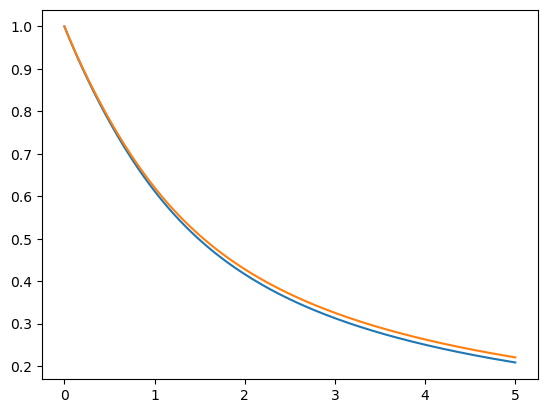

In [7]:
plt.plot(z_list, class_extracted_D1)
plt.plot(z_list, class_D1)

In [8]:
fudge =  mnu/(93.14*h**2)

pars = camb.set_params(H0=h*100, ombh2=omega_b, omch2=omega_cdm+fudge, mnu=mnu, omk=0, tau=0.06, num_massive_neutrinos= 3, neutrino_hierarchy='degenerate',
                       As=2e-9, ns=ns, halofit_version='mead', lmax=3000, WantDerivedParameters = True)#, num_nu_massless = 0.046, num_nu_massive = 3)
pars.DarkEnergy = DarkEnergyPPF(w=w0, wa=wa)

In [9]:
pars.NonLinear = model.NonLinear_none
pars.set_matter_power(redshifts=z_list, kmax=2.0)
results = camb.get_results(pars)
kh, z_list, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
s8 = np.array(results.get_sigma8())
fsigma8 = results.get_fsigma8()
sigma8 = results.get_sigma8()

Note: redshifts have been re-sorted (earliest first)


In [10]:
pars.omegam

0.33502035700481

In [11]:
M.Omega_m()

0.33361799041775303

In [12]:
camb_D1 = np.sqrt(pk[:,0]/pk[0,0])
spl = UnivariateSpline(np.flip(a_list), np.flip(camb_D1), k=4, s=0)
der_spl = spl.derivative(n=1)
camb_extracted_f = np.array([mya*der_spl(mya)/spl(mya) for mya in a_list])
camb_f = np.flip(fsigma8/(sigma8))

In [13]:
#notice that effort takes as input z, the (upper case) Omega densities,
#h, mnu and the dark energy Equation of state parameters
effort_f = np.array([pyeffort.compute_fz(z, omega_cdm/h**2, omega_b/h**2, h, mnu , w0, wa) for z in z_list])
effort_D1 = np.array([pyeffort.compute_Dz(z, omega_cdm/h**2, omega_b/h**2, h, mnu , w0, wa) for z in z_list])
effort_D1_unnorm = np.array([pyeffort.compute_Dz_unnorm(z, omega_cdm/h**2, omega_b/h**2, h, mnu , w0, wa) for z in z_list])

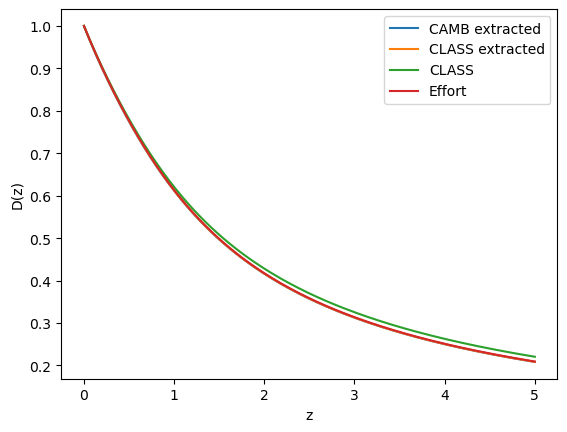

In [14]:
plt.plot(z_list, camb_D1, label = "CAMB extracted")
plt.plot(z_list, class_extracted_D1, label = "CLASS extracted")
plt.plot(z_list, class_D1, label = "CLASS")
plt.plot(z_list, effort_D1, label = "Effort")
plt.xlabel("z")
plt.ylabel("D(z)")
plt.legend()

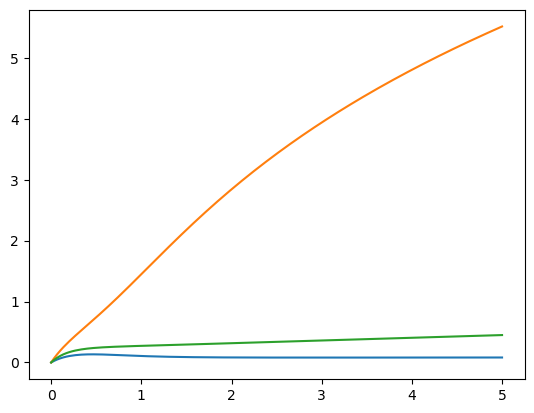

In [15]:
plt.plot(z_list, 100*(1-camb_D1/class_extracted_D1))
plt.plot(z_list, 100*(1-camb_D1/class_D1))
plt.plot(z_list, 100*(1-camb_D1/effort_D1))

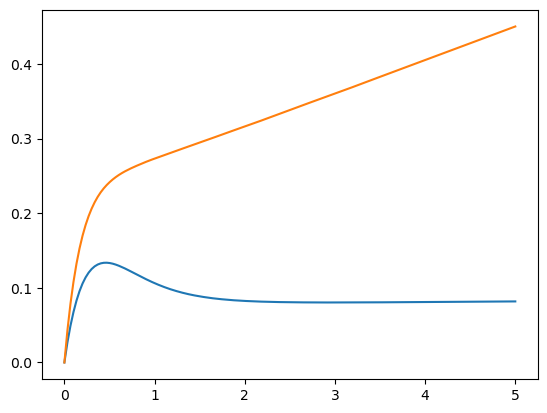

In [16]:
plt.plot(z_list, 100*(1-camb_D1/class_extracted_D1))
plt.plot(z_list, 100*(1-camb_D1/effort_D1))

In [17]:
fsigma8 = results.get_fsigma8()
sigma8 = results.get_sigma8()

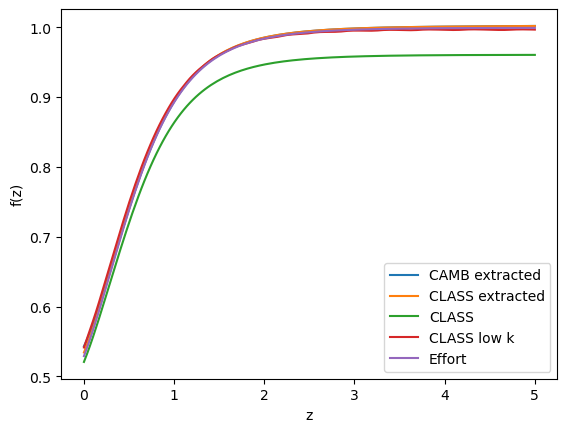

In [18]:
#plt.plot(z_list, camb_f, label = "CAMB")
plt.plot(z_list, camb_extracted_f, label = "CAMB extracted")
plt.plot(z_list, class_extracted_f, label = "CLASS extracted")
plt.plot(z_list, class_f, label = "CLASS")
plt.plot(z_list, class_f_low_k, label = "CLASS low k")
plt.plot(z_list, effort_f, label = "Effort")
plt.xlabel("z")
plt.ylabel("f(z)")
plt.legend()

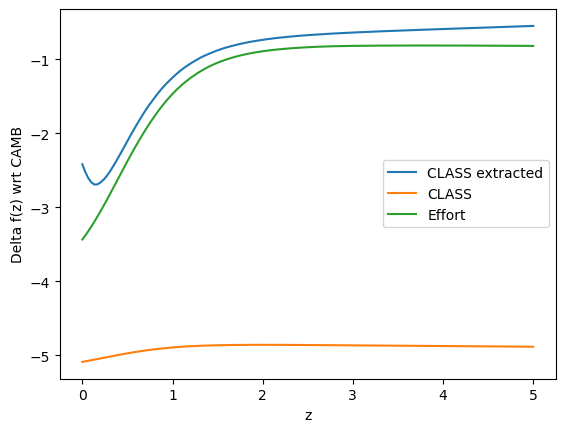

In [19]:
plt.plot(z_list, 100*(1-camb_f/class_extracted_f), label = "CLASS extracted")
plt.plot(z_list, 100*(1-camb_f/class_f), label = "CLASS")
plt.plot(z_list, 100*(1-camb_f/effort_f), label = "Effort")
plt.xlabel("z")
plt.ylabel("Delta f(z) wrt CAMB")
plt.legend()

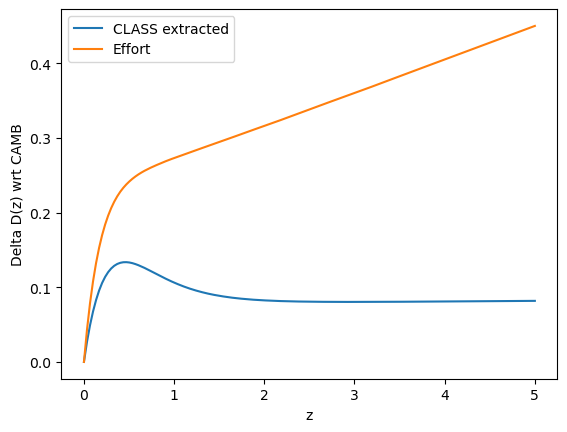

In [20]:
#plt.plot(z_list, camb_f, label = "CAMB")
plt.plot(z_list, 100*(1-camb_D1/class_extracted_D1), label = "CLASS extracted")
#plt.plot(z_list, 100*(1-camb_D1/class_D1), label = "CLASS")
plt.plot(z_list, 100*(1-camb_D1/effort_D1), label = "Effort")
plt.xlabel("z")
plt.ylabel("Delta D(z) wrt CAMB")
plt.legend()

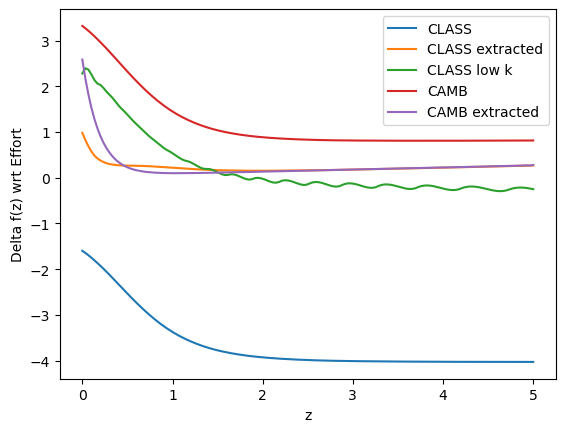

In [21]:
plt.plot(z_list, 100*(1-effort_f/class_f), label = "CLASS")
plt.plot(z_list, 100*(1-effort_f/class_extracted_f), label = "CLASS extracted")
plt.plot(z_list, 100*(1-effort_f/class_f_low_k), label = "CLASS low k")
plt.plot(z_list, 100*(1-effort_f/camb_f), label = "CAMB")
plt.plot(z_list, 100*(1-effort_f/camb_extracted_f), label = "CAMB extracted")
plt.xlabel("z")
plt.ylabel("Delta f(z) wrt Effort")
plt.legend()

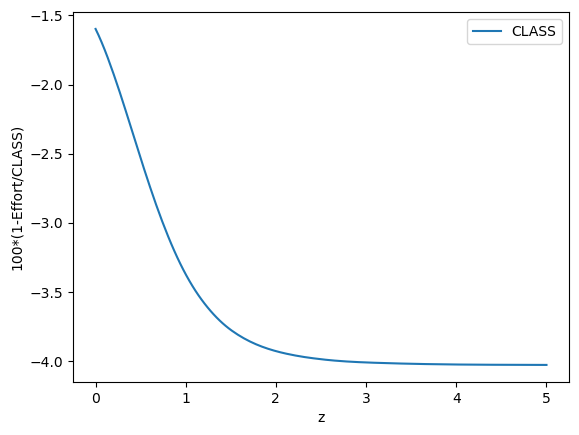

In [22]:
plt.plot(z_list, 100*(1-effort_f/class_f), label = "CLASS")
plt.xlabel("z")
plt.ylabel("100*(1-Effort/CLASS)")
plt.legend()

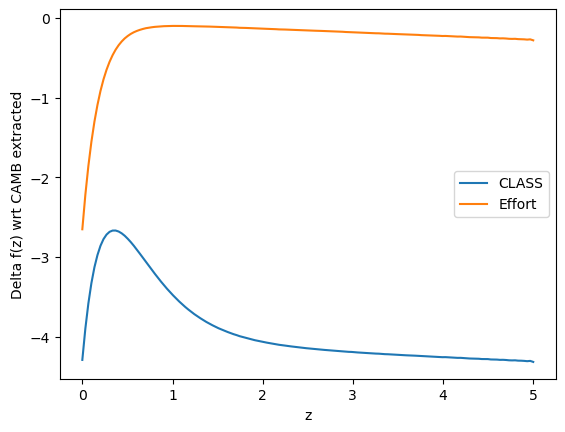

In [23]:
plt.plot(z_list, 100*(1-camb_extracted_f/class_f), label = "CLASS")
#plt.plot(z_list, 100*(1-camb_extracted_f/class_extracted_f), label = "CLASS extracted")
#plt.plot(z_list, 100*(1-camb_extracted_f/class_f_low_k), label = "CLASS low k")
#plt.plot(z_list, 100*(1-camb_extracted_f/camb_f), label = "CAMB")
plt.plot(z_list, 100*(1-camb_extracted_f/effort_f), label = "Effort")
plt.xlabel("z")
plt.ylabel("Delta f(z) wrt CAMB extracted")
plt.legend()